### # Zindi

# Turtle Rescue Forecast Challenge
an accurate prediction will enable Local Ocean Conservation to allocate staff and resources more efficiently <br>
https://zindi.africa/competitions/turtle-rescue-forecast-challenge

![turtle with flower](images/Zavicons.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from datetime import date

from statistics import mean
from math import sqrt
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import HistGradientBoostingRegressor
import sklearn.metrics as metrics

In [2]:
df_turtle = pd.read_csv('data/train.csv')
print(df_turtle.shape)
df_turtle.head()

(18062, 21)


,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,...,Lost_Tags,T_Number,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease
0,2000_RE_0060,2000-12-22,Researcher_25,CaptureSite_0,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,...,NaN,NaN,64.70,62.60,NaN,Unknown,algae at rear of shell,Released,ReleaseSite_50,22/12/00
1,2001_RE_0187,2001-10-28,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,...,NaN,NaN,35.85,31.35,NaN,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,28/10/01
2,2001_RE_0197,2001-11-01,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,...,NaN,NaN,51.80,49.20,NaN,Unknown,clean,Released,ReleaseSite_50,01/11/01
3,2002_RE_0031,2002-03-11,Researcher_32,CaptureSite_0,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,...,NaN,NaN,60.50,59.00,NaN,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,11/03/02
4,2002_RE_0118,2002-08-08,Researcher_25,CaptureSite_0,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,...,NaN,NaN,34.70,33.00,NaN,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,08/08/02


In [3]:
#number of capture sites
df_turtle['CaptureSite'].nunique() # "Capture Site","Area where turtle was captured, as reported by the fisher."

29

In [4]:
# Which Capture sites have the most captures? 
df_turtle.groupby('CaptureSite')['Rescue_ID'].count().reset_index().sort_values('Rescue_ID', ascending=False).head(3)

,CaptureSite,Rescue_ID
18,CaptureSite_25,2574
28,CaptureSite_9,2169
7,CaptureSite_15,1986


## use of the date columns only and performing datetime transformations

In [5]:
# datetime dataframe
df_date = df_turtle.loc[:,['Rescue_ID', 'Date_TimeCaught', 'Date_TimeRelease']]
df_date['Date_TimeCaught'] = pd.to_datetime(df_date['Date_TimeCaught'], format='%Y-%m-%d')
df_date['Date_TimeRelease'] = pd.to_datetime(df_date['Date_TimeRelease'], format='%d/%m/%y', errors='coerce')
df_date['week_caught'] = df_date['Date_TimeCaught'].dt.week
df_date['year_caught'] = df_date['Date_TimeCaught'].dt.year
df_date['week_free'] = df_date['Date_TimeRelease'].dt.week
df_date['year_free'] = df_date['Date_TimeRelease'].dt.year
print(df_date.shape)
df_date.head()

(18062, 7)


,Rescue_ID,Date_TimeCaught,Date_TimeRelease,week_caught,year_caught,week_free,year_free
0,2000_RE_0060,2000-12-22,2000-12-22,51,2000,51.0,2000.0
1,2001_RE_0187,2001-10-28,2001-10-28,43,2001,43.0,2001.0
2,2001_RE_0197,2001-11-01,2001-11-01,44,2001,44.0,2001.0
3,2002_RE_0031,2002-03-11,2002-03-11,11,2002,11.0,2002.0
4,2002_RE_0118,2002-08-08,2002-08-08,32,2002,32.0,2002.0


## splitting off the last year for later model validation

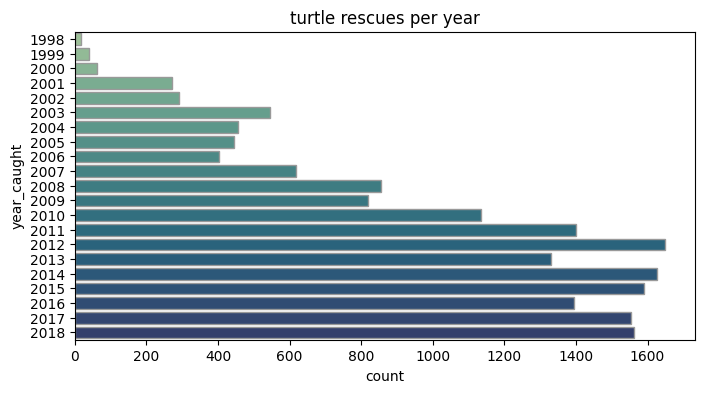

In [6]:
# plotting 
rescue_and_years = df_date[['Rescue_ID', 'year_caught']]
fig = plt.figure(figsize=(8, 4))
sns.countplot(y="year_caught", palette='crest', edgecolor='.6',data=rescue_and_years)
plt.title('turtle rescues per year');

+ the year 2018 is used for model validation
+ the beginning years (1998 - 2000) will be dropped because the less amount of rescues could indicate that the project structures were not fully established

# baseline model
predict the number of turtle rescues of 2016 by expecting the same number as 2015

In [7]:
# dataframe from columns used for baseline model
df_base = pd.merge(df_turtle.loc[:,['Rescue_ID', 'Date_TimeCaught', 'CaptureSite']],df_date.loc[:,['Rescue_ID','week_caught', 'year_caught']])

# train test split for base model
df_train_base = df_base.loc[df_date['year_caught'] == 2017]
df_test_base = df_base.loc[df_date['year_caught'] == 2018]
print(f'shape of dataframe used for prediction: {df_train_base.shape}')
print(f'shape of dataframe used for validation: {df_test_base.shape}')

shape of dataframe used for prediction: (1554, 5)
shape of dataframe used for validation: (1561, 5)


In [8]:
#rescue operations per capture site per week in 2017 to predict for 2018
model_2018 = df_train_base.groupby(['CaptureSite', 'week_caught'])['Rescue_ID'].count().rename('count').reset_index().sort_values('CaptureSite', ascending=False)
# actual rescue operations per capture site per week in 2018
actual_2018 = df_test_base.groupby(['CaptureSite', 'week_caught'])['Rescue_ID'].count().rename('count').reset_index().sort_values('CaptureSite', ascending=False)

In [9]:
# make dataframe with all the weeks of 2016
df_week_base = pd.date_range(start='2018-01-01', end='2018-12-31', freq='W')
df_week_base = pd.DataFrame({'datetime':df_week_base.date})

# add capture sites
out = pd.MultiIndex.from_product([df_week_base['datetime'].unique(),model_2018['CaptureSite'].unique()]).to_frame().reset_index(drop=True)
out.columns = ['datetime', 'CaptureSite']
df_week_base = pd.DataFrame(out)

# week column and count column
df_week_base['datetime'] = pd.to_datetime(df_week_base['datetime'], format='%Y-%m-%d')
df_week_base['week_caught'] = df_week_base['datetime'].dt.week
df_week_base['count'] = 0
print(df_week_base.shape)
df_week_base.head()

(1456, 4)


,datetime,CaptureSite,week_caught,count
0,2018-01-07,CaptureSite_9,1,0
1,2018-01-07,CaptureSite_8,1,0
2,2018-01-07,CaptureSite_7,1,0
3,2018-01-07,CaptureSite_6,1,0
4,2018-01-07,CaptureSite_5,1,0


In [10]:
# add the predicted and actual values for each week and capture site by merging the dataframes
df_week_base = df_week_base.merge(model_2018, how='outer', on=('CaptureSite', 'week_caught'), suffixes=('', '_pred'))
df_week_base = df_week_base.merge(actual_2018, how='outer', on=('CaptureSite', 'week_caught'), suffixes=('', '_actual'))
df_week_base.fillna(value=0, inplace=True)
df_week_base['count_pred'] = df_week_base['count_pred'].astype('int')
df_week_base['count_actual'] = df_week_base['count_actual'].astype('int')
print(df_week_base.shape)
df_week_base.head(3)

(1478, 6)


,datetime,CaptureSite,week_caught,count,count_pred,count_actual
0,2018-01-07 00:00:00,CaptureSite_9,1,0.0,0,3
1,2018-01-07 00:00:00,CaptureSite_8,1,0.0,1,0
2,2018-01-07 00:00:00,CaptureSite_7,1,0.0,0,0


In [11]:
# now the dataframe is ready to calculate the rmse score for the whole year
rmse_base = sqrt(mean_squared_error(df_week_base['count_actual'], df_week_base['count_pred']))
print(f'RMSE for baseline model = {round(rmse_base, 4)}')


RMSE for baseline model = 2.1043


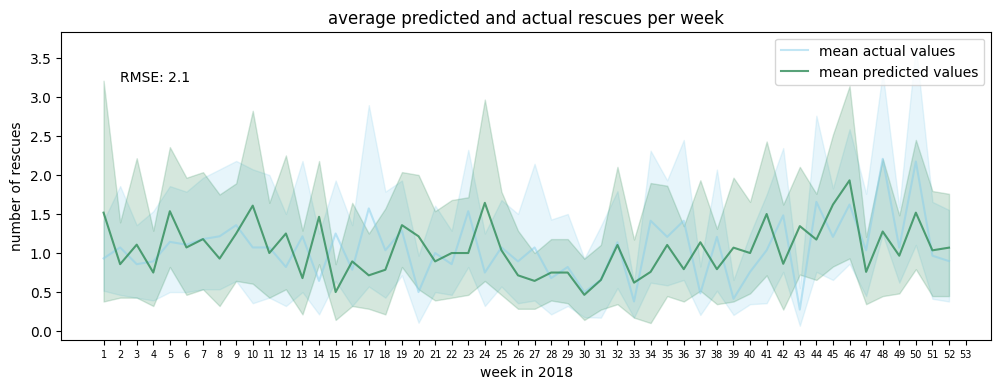

In [12]:
fig = plt.figure(figsize=(12,4))
sns.lineplot(data=df_week_base, x='week_caught', y='count_actual', label='mean actual values',  color='skyblue', sizes=(7,7), alpha=0.5)
sns.lineplot(data=df_week_base, x='week_caught', y='count_pred', label='mean predicted values', color='seagreen', sizes=(3,3), alpha=0.8)

plt.text(2, 3.2, f'RMSE: {round(rmse_base, 2)}', fontsize=10)
plt.title('average predicted and actual rescues per week')
plt.xlabel('week in 2018')
plt.xticks(range(1,54), fontsize=7)
plt.ylabel('number of rescues');

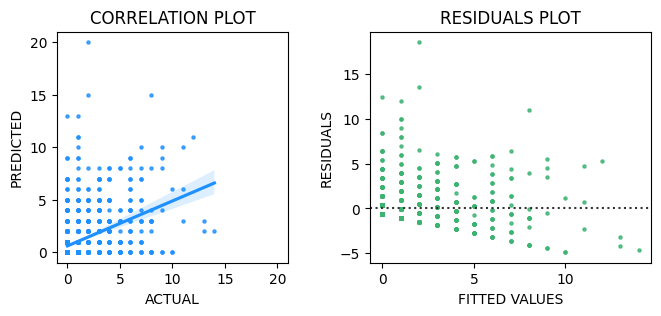

In [13]:
# plots for error analysis
fig, ax = plt.subplots(ncols=2, figsize = (8,3))

sns.regplot(data=df_week_base, x='count_actual', y='count_pred', color='dodgerblue', scatter_kws={'s':5}, ax=ax[0])
sns.residplot(data=df_week_base, x='count_actual', y='count_pred', color='mediumseagreen', scatter_kws={'s':5}, ax=ax[1])

ax[0].set_aspect('equal', adjustable="datalim")
ax[0].set_box_aspect(1)
minimum = np.min((ax[0].get_xlim(),ax[0].get_ylim()))
maximum = np.max((ax[0].get_xlim(),ax[0].get_ylim()))
ax[0].set_xlim(minimum,maximum)
ax[0].set_ylim(minimum,maximum)
ax[0].set(xlabel='ACTUAL', ylabel='PREDICTED', title='CORRELATION PLOT')

ax[1].set_aspect('auto')
ax[1].set(xlabel='FITTED VALUES', ylabel='RESIDUALS', title='RESIDUALS PLOT');

+ RMSE is relatively high the baseline model did not deliver a good prediction

## prepare dataframe for ML modelling

In [14]:
# simple set for machine learning
df_turtle_ml = pd.merge(df_turtle.loc[:,['Rescue_ID', 'CaptureSite']],df_date.loc[:,['Rescue_ID','week_caught', 'year_caught', 'Date_TimeCaught']])

# count the number of entries as captures
df_turtle_ml['rescue_count'] = df_turtle_ml.groupby(['year_caught', 'week_caught','CaptureSite'])['CaptureSite'].transform('count')
print(df_turtle_ml.shape)
df_turtle_ml.head()

(18062, 6)


,Rescue_ID,CaptureSite,week_caught,year_caught,Date_TimeCaught,rescue_count
0,2000_RE_0060,CaptureSite_0,51,2000,2000-12-22,1
1,2001_RE_0187,CaptureSite_0,43,2001,2001-10-28,1
2,2001_RE_0197,CaptureSite_0,44,2001,2001-11-01,1
3,2002_RE_0031,CaptureSite_0,11,2002,2002-03-11,1
4,2002_RE_0118,CaptureSite_0,32,2002,2002-08-08,2


In [15]:
def plot_all_weeks(df, alpha=0.05):
    toidx = df['CaptureSite'].str.rsplit('_').str[-1].astype(int).sort_values()
    df = df.reindex(index= toidx.index)

    cp = sns.color_palette('crest_r', as_cmap=True)

    fig, ax= plt.subplots(figsize=(17,14))
    plot = sns.scatterplot(data=df, x='week_caught', y='CaptureSite', size='rescue_count',sizes=(15,2500), palette=cp, hue='year_caught', alpha=alpha, legend='full')
    plt.legend(bbox_to_anchor=(1,1),loc=2)
    plt.xlabel('WEEK OF THE YEAR')
    plt.xticks(range(1,54))
    plt.ylabel('')
    plt.show();

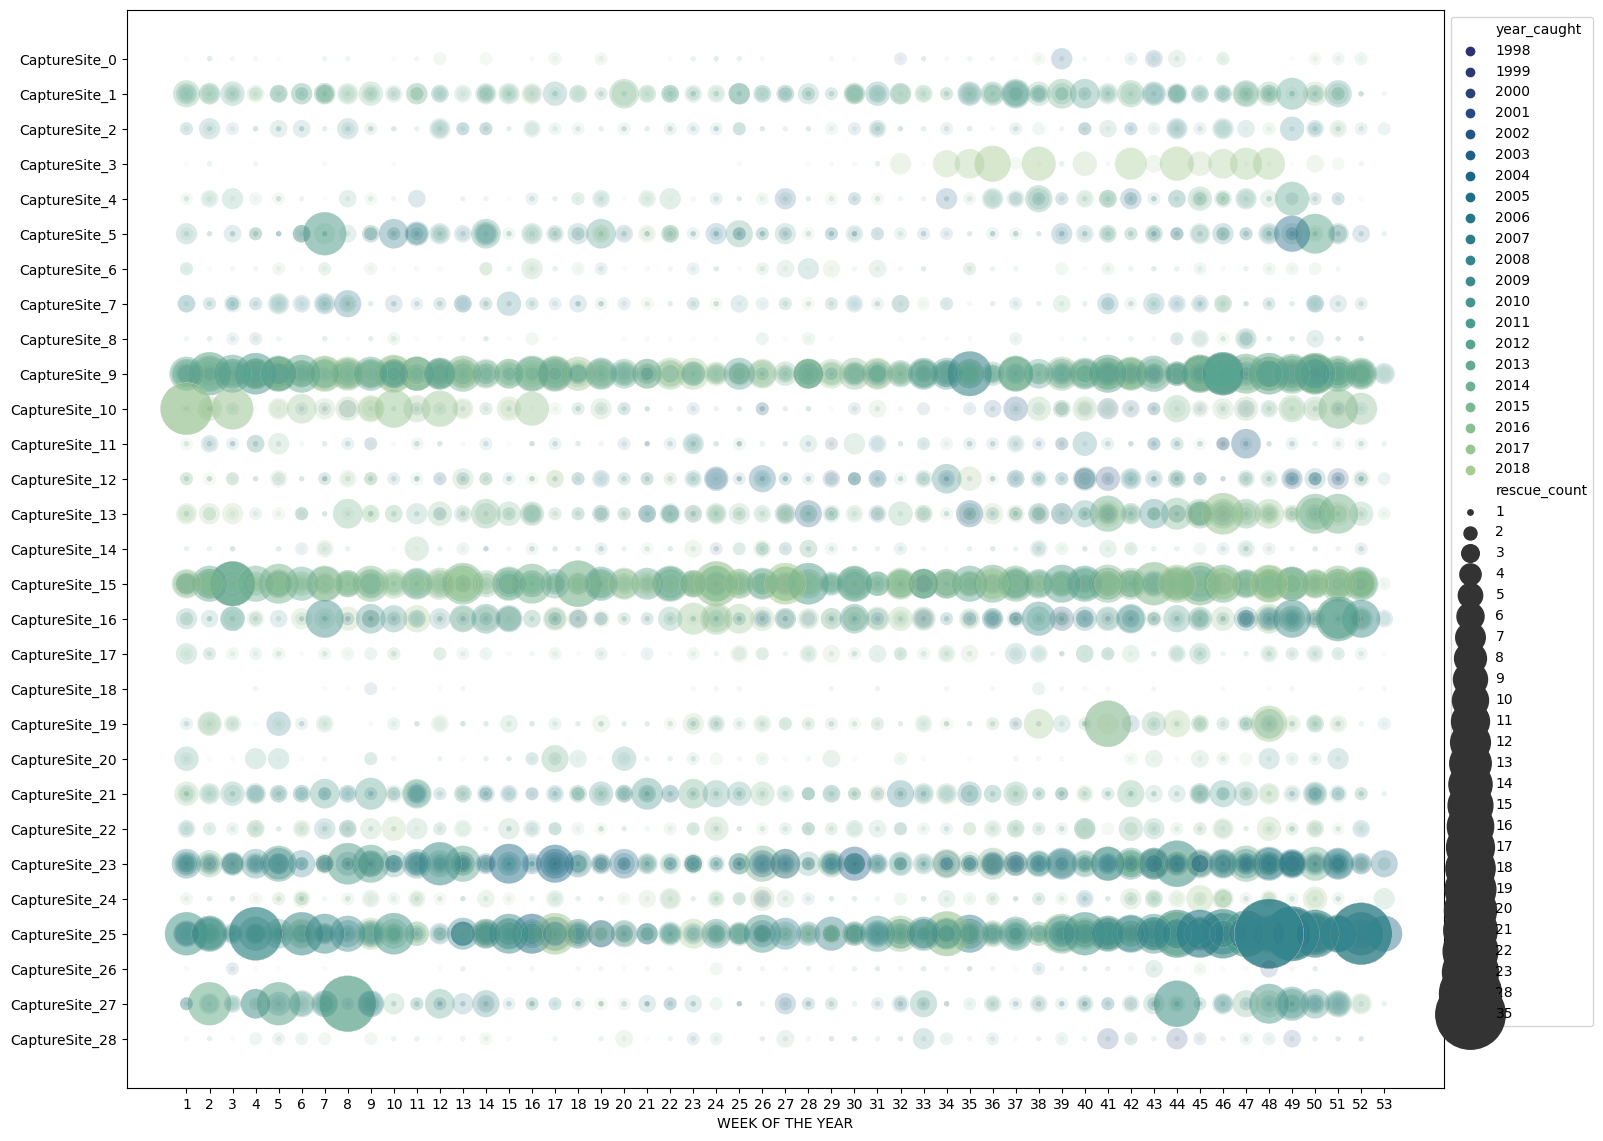

In [16]:
plot_all_weeks(df_turtle_ml)

+ the graph shows that in some weeks no turtle was rescued at some capture site - all those weeks need a rescue count value of zero

In [17]:
# create an date_range data frame with all weeks per capture site
first = df_turtle_ml['Date_TimeCaught'].min()
last = df_turtle_ml['Date_TimeCaught'].max()

df_week = pd.date_range(start=first, end=last, freq='W')
df_week = pd.DataFrame({'datetime':df_week.date})

out = pd.MultiIndex.from_product([df_week['datetime'].unique(),df_turtle_ml['CaptureSite'].unique()]).to_frame().reset_index(drop=True)
out.columns = ['datetime', 'CaptureSite']
df_week = pd.DataFrame(out)
print(f'roughly estimated number of df rows: {21*52*29}') # ~21 years with ~52 weeks at 29 capture sites
print(f'actual number of df rows: {df_week.shape[0]} -> great')

# modify datetime
df_week['datetime'] = pd.to_datetime(df_week['datetime'], format='%Y-%m-%d')
df_week['week_caught'] = df_week['datetime'].dt.week
df_week['year_caught'] = df_week['datetime'].dt.year
df_week['rescue_count'] = 0
df_week.head()

roughly estimated number of df rows: 31668
actual number of df rows: 31349 -> great


,datetime,CaptureSite,week_caught,year_caught,rescue_count
0,1998-04-19,CaptureSite_0,16,1998,0
1,1998-04-19,CaptureSite_1,16,1998,0
2,1998-04-19,CaptureSite_10,16,1998,0
3,1998-04-19,CaptureSite_11,16,1998,0
4,1998-04-19,CaptureSite_12,16,1998,0


In [23]:
# add the predicted and actual values for each week and capture site by merging the dataframes
df_rescues = df_week.merge(df_turtle_ml.loc[:,['CaptureSite', 'year_caught','week_caught','rescue_count']],
                             how='left', on=('CaptureSite', 'year_caught', 'week_caught'), suffixes=('_zero', ''))

df_rescues['rescue_count'].fillna(value=0, inplace=True)
df_rescues['rescue_count'] = df_rescues['rescue_count'].astype('int')
df_rescues.drop_duplicates(inplace=True)
df_rescues = df_rescues.dropna().reset_index(drop=True)
print(df_rescues.shape)
df_rescues.tail()

(31349, 6)


,datetime,CaptureSite,week_caught,year_caught,rescue_count_zero,rescue_count
31344,2018-12-30,CaptureSite_5,52,2018,0,0
31345,2018-12-30,CaptureSite_6,52,2018,0,0
31346,2018-12-30,CaptureSite_7,52,2018,0,1
31347,2018-12-30,CaptureSite_8,52,2018,0,0
31348,2018-12-30,CaptureSite_9,52,2018,0,3


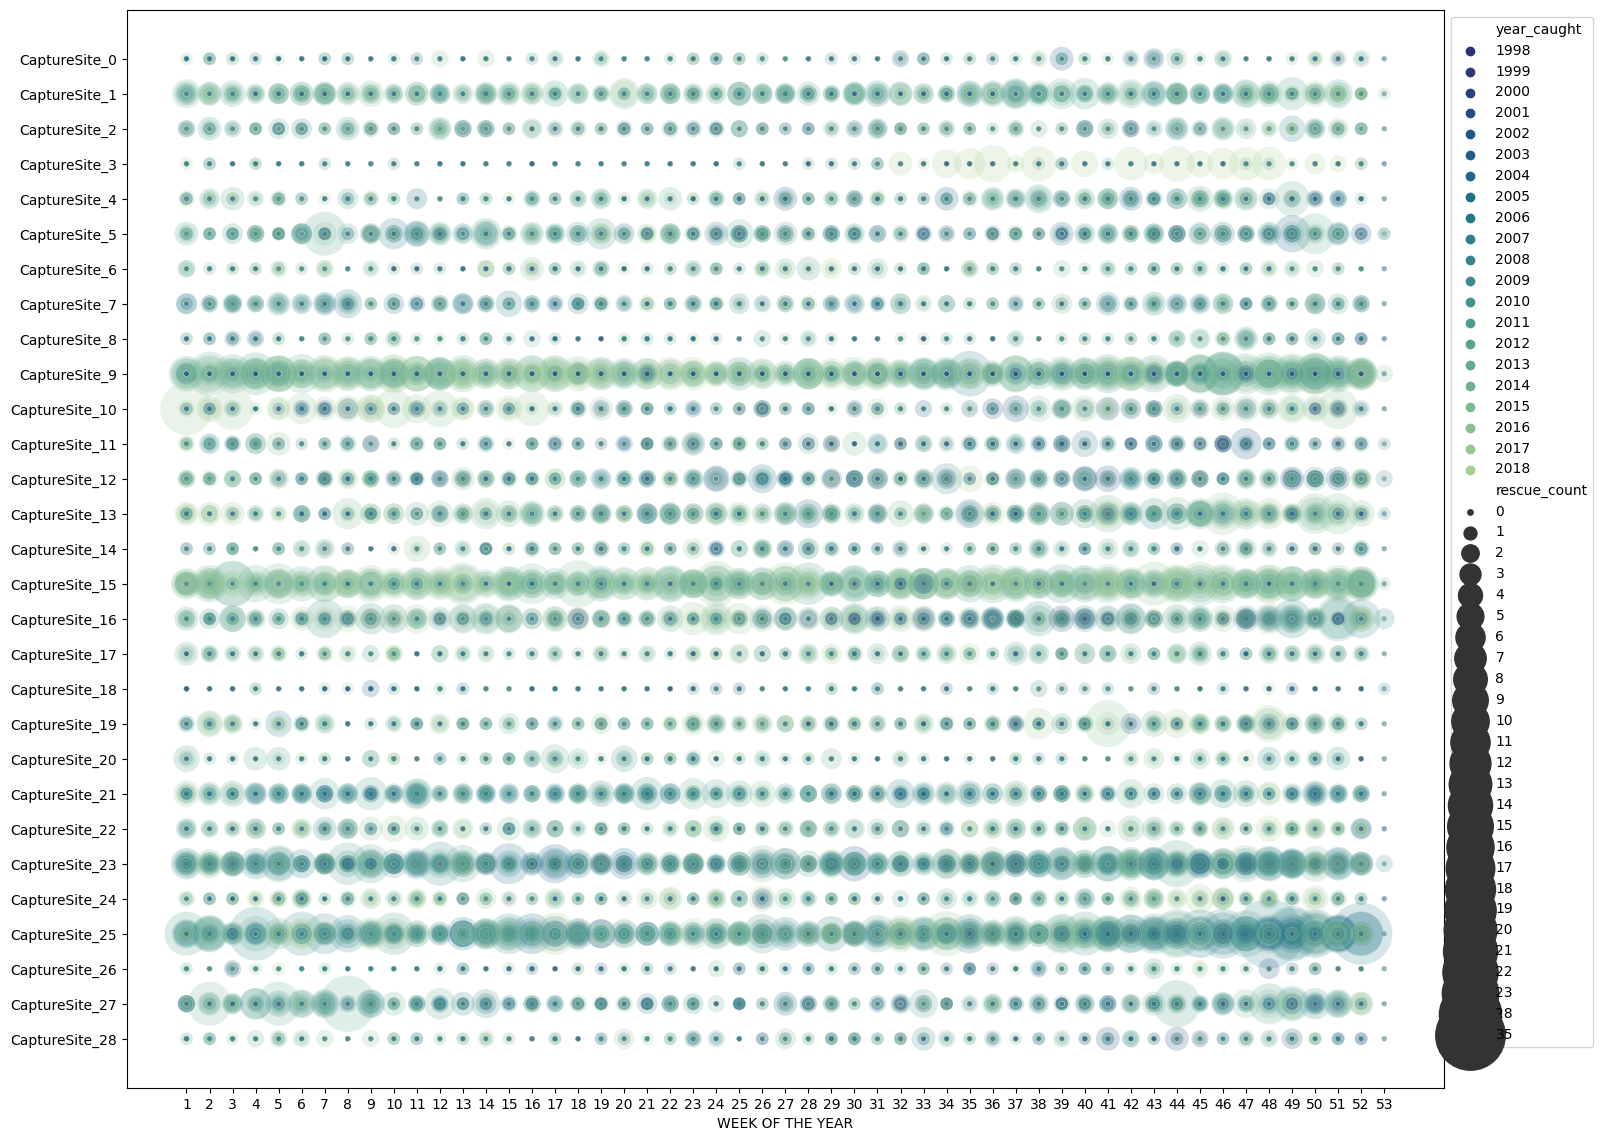

In [19]:
plot_all_weeks(df_rescues, 0.2)

## engineering of lag features for timeseries modelling
get values from one and two weeks ago as well as from one and two years ago

In [24]:
def compute_week_shift(df):
  df['group_no'] = df.groupby(['CaptureSite']).ngroup()
  tmp = df[['datetime','rescue_count','group_no']].set_index(['group_no','datetime'])\
                                      .unstack('group_no')\
                                      .resample('W').asfreq() # weekly frequency
  tmp1 = tmp.shift(1).stack('group_no')['rescue_count'].rename('last_1w')
  tmp2 = tmp.shift(2).stack('group_no')['rescue_count'].rename('last_2w')

  df = df.join(tmp1, on=['datetime','group_no'])
  df = df.join(tmp2, on=['datetime','group_no'])
  df = df.drop(columns=['group_no'])
  return df

  # https://stackoverflow.com/questions/47755584/efficient-shifting-based-on-date-within-groups-in-pandas

In [25]:
# shift values by one and two weeks
df_rescues = compute_week_shift(df_rescues)

# shift values by one and two years
df_rescues['last_1y'] = df_rescues.groupby([df_rescues['CaptureSite'], df_rescues['datetime'].dt.week])['rescue_count'].shift(1)
df_rescues['last_2y'] = df_rescues.groupby([df_rescues['CaptureSite'], df_rescues['datetime'].dt.week])['rescue_count'].shift(2)
df_rescues = df_rescues.fillna(method='bfill')
# sort to see result
df_rescues.sort_values(by=['CaptureSite','week_caught', 'year_caught'], inplace=True)
df_rescues.tail(10)

,datetime,CaptureSite,week_caught,year_caught,rescue_count_zero,rescue_count,last_1w,last_2w,last_1y,last_2y
23779,2013-12-29,CaptureSite_9,52,2013,0,8,5.0,13.0,5.0,5.0
25287,2014-12-28,CaptureSite_9,52,2014,0,6,10.0,11.0,8.0,5.0
26795,2015-12-27,CaptureSite_9,52,2015,0,6,0.0,4.0,6.0,8.0
28332,2017-01-01,CaptureSite_9,52,2017,0,7,0.0,5.0,6.0,6.0
29840,2017-12-31,CaptureSite_9,52,2017,0,7,8.0,11.0,7.0,6.0
31348,2018-12-30,CaptureSite_9,52,2018,0,3,5.0,12.0,7.0,7.0
1101,1999-01-03,CaptureSite_9,53,1999,0,0,0.0,0.0,0.0,0.0
10178,2005-01-02,CaptureSite_9,53,2005,0,0,0.0,0.0,0.0,0.0
17747,2010-01-03,CaptureSite_9,53,2010,0,0,3.0,0.0,0.0,0.0
26824,2016-01-03,CaptureSite_9,53,2016,0,2,6.0,0.0,0.0,0.0


In [26]:
# train test split for ML
df_rescues = df_rescues.set_index(['CaptureSite','datetime'])
df_rescues.sort_index(inplace=True)
df_train_ml = df_rescues.loc[(df_rescues['year_caught'] < 2018) & (df_rescues['year_caught'] >= 2001)]
df_test_ml = df_rescues.loc[(df_rescues['year_caught'] == 2018)]

print(df_train_ml.shape)
print(df_test_ml.shape)

(25723, 8)
(1508, 8)


In [27]:
X_train = df_train_ml[['last_1y', 'last_2y', 'last_1w', 'last_2w']]
y_train = df_train_ml[['rescue_count']]
X_test = df_test_ml[['last_1y', 'last_2y', 'last_1w', 'last_2w']]
y_test = df_test_ml[['rescue_count']]
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head()

(25723, 4) (25723, 1) (1508, 4) (1508, 1)


last_1y  last_2y  last_1w  last_2w
CaptureSite   datetime                                      
CaptureSite_0 2001-01-07      0.0      0.0      0.0      1.0
              2001-01-14      0.0      0.0      0.0      0.0
              2001-01-21      0.0      0.0      0.0      0.0
              2001-01-28      0.0      0.0      0.0      0.0
              2001-02-04      0.0      0.0      0.0      0.0

## modelling

In [30]:
# use a regression model to predict
model_hgb = HistGradientBoostingRegressor(loss='poisson')
model_hgb.fit(X_train, y_train)

y_true = y_test.values
y_pred = model_hgb.predict(X_test)

rmse_base = sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE for hgb model = {round(rmse_base, 4)}')

RMSE for hgb model = 1.4301


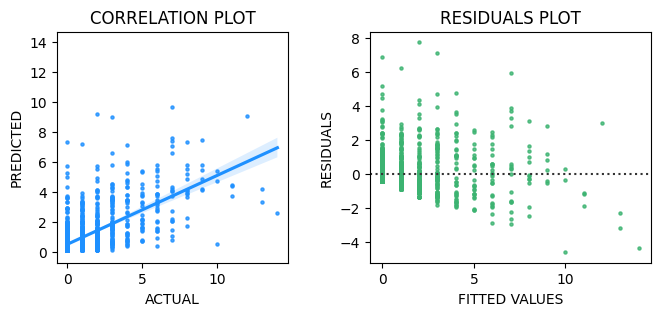

In [31]:
# plots for error analysis
fig, ax = plt.subplots(ncols=2, figsize = (8,3))

sns.regplot(x=y_true, y=y_pred, color='dodgerblue', scatter_kws={'s':5}, ax=ax[0])
sns.residplot(x=y_true, y=y_pred, color='mediumseagreen', scatter_kws={'s':5}, ax=ax[1])

ax[0].set_aspect('equal', adjustable="datalim")
ax[0].set_box_aspect(1)
minimum = np.min((ax[0].get_xlim(),ax[0].get_ylim()))
maximum = np.max((ax[0].get_xlim(),ax[0].get_ylim()))
ax[0].set_xlim(minimum,maximum)
ax[0].set_ylim(minimum,maximum)
ax[0].set(xlabel='ACTUAL', ylabel='PREDICTED', title='CORRELATION PLOT')

ax[1].set_aspect('auto')
ax[1].set(xlabel='FITTED VALUES', ylabel='RESIDUALS', title='RESIDUALS PLOT');

In [32]:
df_eval = df_test_ml[['rescue_count', 'week_caught']]
df_eval['count_pred'] = y_pred
df_eval.tail()

rescue_count  week_caught  count_pred
CaptureSite   datetime                                         
CaptureSite_9 2018-12-02             6           48    3.854914
              2018-12-09             6           49    3.857291
              2018-12-16            12           50    9.067472
              2018-12-23             5           51    5.397659
              2018-12-30             3           52    9.013278

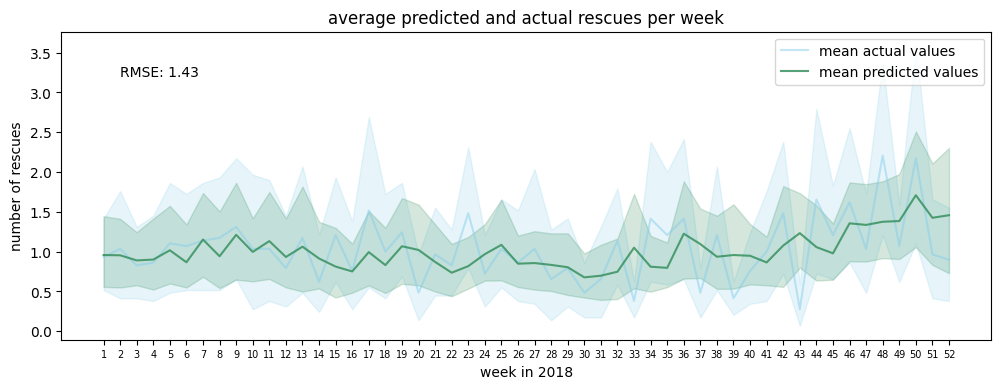

In [33]:
fig = plt.figure(figsize=(12,4))
sns.lineplot(data=df_eval, x='week_caught', y='rescue_count', label='mean actual values', color='skyblue', sizes=(7,7), alpha=0.5)
sns.lineplot(data=df_eval, x='week_caught', y='count_pred', label='mean predicted values', color='seagreen', sizes=(3,3), alpha=0.8)

plt.text(2, 3.2, f'RMSE: {round(rmse_base, 2)}', fontsize=10)
plt.title('average predicted and actual rescues per week')
plt.xlabel('week in 2018')
plt.xticks(range(1,53), fontsize=7)
plt.ylabel('number of rescues');

+ feature engineering of lag times for timeseries and using ML regression model did improve the RMSE score compared to the baseline model

## further improvements
+ using stronger models for forecasting like ARIMA and family or darts
+ use more features like the foraging ground or the rescuer